In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import m_p, m_e, c
import gappa as gp
from gammapy.catalog import SourceCatalogGammaCat
from gammapy.utils.coordinates import galactic
from gammapy.modeling.models import create_crab_spectral_model as CrabSpectrum
from scipy.stats import kde

In [4]:
col_names = ['N','filename', 'GLON', 'GLAT', 'R_pwn', 'R_pwn_deg', 'distance',
       'ph_flux_above100GeV', 'nh', 'age', 'X', 'Y', 'Z', 'v_X', 'v_Y', 'v_Z',
       'v_3d', 'E_sn', 'M_ej', 'l0', 't0', 'eta', 'eps', 'ebreak', 'alpha1',
       'alpha2', 'Tfir', 'Ufir', 'Tnir', 'Unir']

In [5]:
final = pd.read_csv('../PWNe_final_population.txt', delimiter='\t', header=0, index_col=0, usecols=range(len(col_names)), names=col_names)
final['filename'] = '../xml/ph_sed_pwn_'+final.index.astype(str)+'.txt'

In [6]:
final2 = final[((final.GLAT)<=3.) & ((final.GLAT)>=-4.)]
final2 = final2[((final2.GLON)<=130.) & ((final2.GLON)>=-70)]


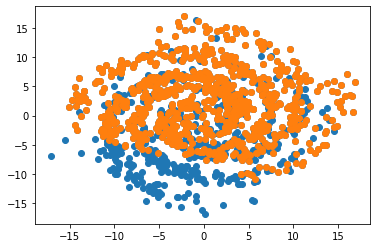

In [7]:
plt.scatter(final.Y, -final.X)
plt.scatter(final2.Y, -final2.X)

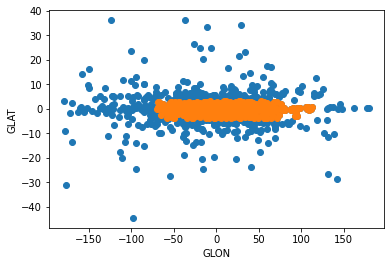

In [8]:
plt.scatter(final.GLON, final.GLAT)
plt.scatter(final2.GLON, final2.GLAT)
plt.xlabel('GLON')
plt.ylabel('GLAT')
plt.savefig('glon_glat.png')

In [9]:
1316/len(final), len(final2)

(1.0130869899923018, 830)

In [10]:
def import_and_transform(filename, energy_cut1=1*u.TeV, energy_cut2=10*u.PeV):
    dato = np.loadtxt(filename).T
    en = dato[0]*u.MeV
    diff_flux = (dato[1]/u.MeV/u.cm**2/u.s)
    integral = np.trapz(diff_flux[(en>=energy_cut1) & (en<=energy_cut2)], en[(en>=energy_cut1) & (en<=energy_cut2)])
    integral2 = np.trapz(diff_flux[(en>=energy_cut1) & (en<=energy_cut2)] * en[(en>=energy_cut1) & (en<=energy_cut2)], en[(en>=energy_cut1) & (en<=energy_cut2)])
    return integral.value, integral2.to('erg/(s*cm**2)').value

In [11]:
def plot_loghist(bb, bins, title, xlabel):#, filen=None):
    plt.figure(figsize=(6,4))
    logbins = np.logspace(np.log10(min(bb)), np.log10(max(bb)), bins+1)
    a = plt.hist(bb, logbins)
    plt.title(title)
    plt.semilogx()
    plt.xlabel(xlabel)
    plt.ylabel('N')
    plt.tight_layout()
#     if filen != None:
#         plt.savefig(filen, dpi=100, bbox_inches='tight')

In [12]:
def plotLogNlogS(fl, binning, density=False, label=None, color='C0'):
    fl = np.nan_to_num(fl)
    logs_min = -10
    logs_max = 1
    nbins = binning*(logs_max - logs_min)
    bins_lognlogs = np.logspace(logs_min, logs_max, nbins)
    if label==None:
        n, bins, patches = plt.hist(fl, bins=bins_lognlogs, density=density, histtype='step', cumulative=-1, lw=2)
    else:
        n, bins, patches = plt.hist(fl, bins=bins_lognlogs, density=density, histtype='step', cumulative=-1, lw=2)
    f = np.sqrt(bins[1:] * bins[:-1])
    plt.fill_between(f, n - np.sqrt(n), n + np.sqrt(n), color=color, label=label,
                     alpha=0.3)

    plt.loglog()
    return n, bins

In [13]:
ph_fl_01 = []
for i in range(len(final)):
    a, b = import_and_transform(final.filename.iloc[i], energy_cut1=0.1*u.TeV, energy_cut2=1000*u.TeV)
    ph_fl_01.append(a)
    
ph_fl_1 = []
for i in range(len(final)):
    a, b = import_and_transform(final.filename.iloc[i], energy_cut1=1*u.TeV, energy_cut2=1000*u.TeV)
    ph_fl_1.append(a)

In [14]:
crab = CrabSpectrum('meyer')
emin01, emin1, emax = [0.1, 1, 1000] * u.TeV

crab_01 = crab.integral(emin01, emax).value
crab_1 = crab.integral(emin1, emax).value

flux_int_cu = (ph_fl_01 / crab_01)
flux_int_cu01 = (ph_fl_1 / crab_1)

In [15]:
final['cr_fl_1'] = flux_int_cu
final['cr_fl_01'] = flux_int_cu01

In [16]:
len(final)/1316

0.9870820668693009

In [17]:
final.cr_fl_1[final.cr_fl_1 >= 1]

Series([], Name: cr_fl_1, dtype: float64)

In [18]:
final.cr_fl_01[final.cr_fl_01 >= 1]

N
317     1.356706
2304    1.762711
Name: cr_fl_01, dtype: float64

In [19]:
# finalb = final.drop([269, 2492])
# finalb = final.drop([269, 625, 2710, 2492])
# finalb = final.drop([591,612, 1174, 1343, 1466, 1469, 1692, 2116, 2474, 2641])
# finalb = final.drop([121, 371, 591,612, 1174, 1343, 1466, 1469,1653, 1692, 1916, 2116, 2455, 2474,2475, 2641, 2783])


# finalb = final.drop([269, 970,2304, 317, 2492])

# finalb = final.drop(2304)
# finalb = final.drop(2304)


In [20]:
# finalb2 = finalb[np.abs(finalb.GLAT)<=3.]
final2 = final[(final.GLAT<=2.) & (final.GLAT>=-2.) & (final.GLON<=130.) & (final.GLON>=-70)]

In [21]:
len(final2)

660

In [22]:
gammacat_file = 'gammacat.fits.gz'

In [23]:
gammacat = SourceCatalogGammaCat(gammacat_file)

In [24]:
gammacat_pwn_glon, gammacat_pwn_glat = [], []
for source in gammacat:
    if source.data.where.startswith('gal'):
        if 'pwn' or 'unid' in  source.data.classes:
            try:
                gammacat_pwn_glon.append(source.spatial_model().lon_0.value)
                gammacat_pwn_glat.append(source.spatial_model().lat_0.value)
            except:
                None

gammacat_pwn_glat  = np.array(gammacat_pwn_glat)
gammacat_pwn_glon  = np.array(gammacat_pwn_glon)
gammacat_pwn_glon = np.concatenate([gammacat_pwn_glon[gammacat_pwn_glon>180] - 360, gammacat_pwn_glon[gammacat_pwn_glon<180]])

k = kde.gaussian_kde(np.array([gammacat_pwn_glon, gammacat_pwn_glat]))
nbins=200
xi, yi = np.mgrid[gammacat_pwn_glon.min():gammacat_pwn_glon.max():nbins*1j, gammacat_pwn_glat.min():gammacat_pwn_glat.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
zi /= zi.max()

In [25]:
glat = final.GLAT
glon = final.GLON
glon = np.concatenate([glon[glon>180] - 360, glon[glon<180]])

k1 = kde.gaussian_kde(np.array([glon, glat]))
nbins=200
xi1, yi1 = np.mgrid[glon.min():glon.max():nbins*1j, glat.min():glat.max():nbins*1j]
zi1 = k1(np.vstack([xi1.flatten(), yi1.flatten()]))
zi1 /= zi1.max()

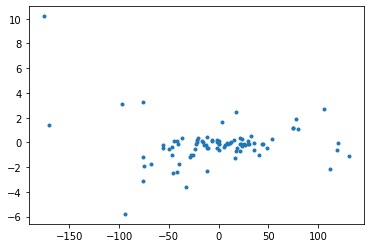

In [26]:
plt.plot(gammacat_pwn_glon, gammacat_pwn_glat, '.')

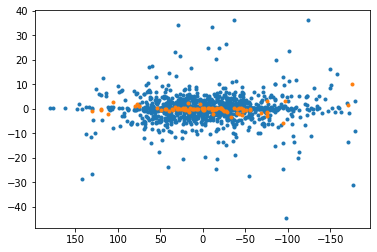

In [27]:
plt.plot(final.GLON, final.GLAT, '.')
plt.plot(gammacat_pwn_glon, gammacat_pwn_glat, '.')
plt.plot()
plt.gca().invert_xaxis()

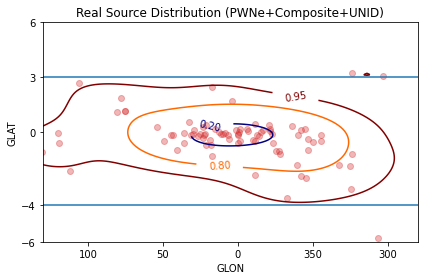

In [28]:
plt.scatter(gammacat_pwn_glon, gammacat_pwn_glat, c='C3', alpha=0.33)
CS =plt.contour(xi, yi, zi.reshape(xi.shape), np.array([0.05, 0.2, 0.8]), cmap=plt.cm.jet_r)
CS.levels = [(1-val) for val in CS.levels]
plt.clabel(CS, CS.levels, inline=True, fmt=f'%.2f',  fontsize=10)
plt.gca().invert_xaxis()
plt.axhline(-4)
plt.axhline(3)
plt.xlabel('GLON')
plt.ylabel('GLAT')
plt.xlim(130, -120)
plt.ylim(-6,6)
plt.gca().set_xticks([100,50,0,-50, -100])
plt.gca().set_yticks([-6,-4, 0, 3, 6])

plt.gca().set_xticklabels(['100', '50' , '0', '350', '300'])
plt.title('Real Source Distribution (PWNe+Composite+UNID)')
plt.tight_layout()
plt.savefig('real_source_distr.png', dpi=150, bbox_inches='tight')

(-10.0, 10.0)

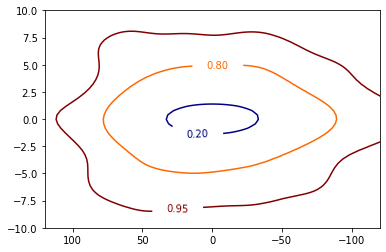

In [29]:
CS =plt.contour(xi1, yi1, zi1.reshape(xi1.shape), np.array([0.05, 0.2, 0.8]), cmap=plt.cm.jet_r)
CS.levels = [(1-val) for val in CS.levels]
plt.clabel(CS, CS.levels, inline=True, fmt=f'%.2f',  fontsize=10)
plt.gca().invert_xaxis()
plt.xlim(120, -120)
plt.ylim(-10, 10)

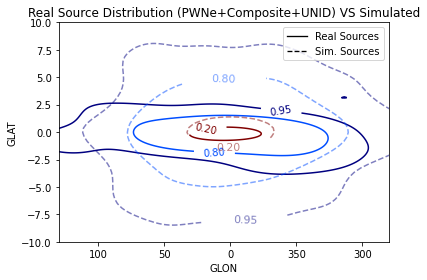

In [30]:
CS =plt.contour(xi, yi, zi.reshape(xi.shape), np.array([0.05, 0.2, 0.8]), cmap=plt.cm.jet)
CS.levels = [(1-val) for val in CS.levels]
plt.clabel(CS, CS.levels, inline=True, fmt=f'%.2f',  fontsize=10)
plt.axvline(380, label='Real Sources', c='k', lw=1.33)
plt.axvline(380, label='Sim. Sources', c='k', lw=1.33, ls='--')
CS =plt.contour(xi1, yi1, zi1.reshape(xi1.shape), np.array([0.05, 0.2, 0.8]), cmap=plt.cm.jet, alpha=0.5, linestyles='--')
CS.levels = [(1-val) for val in CS.levels]
plt.clabel(CS, CS.levels, inline=True, fmt=f'%.2f',  fontsize=11)
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(120, -120)
plt.ylim(-10, 10)
plt.xlabel('GLON')
plt.ylabel('GLAT')
plt.xlim(130, -120)
plt.gca().set_xticks([100,50,0,-50, -100])

plt.gca().set_xticklabels(['100', '50' , '0', '350', '300'])
plt.title('Real Source Distribution (PWNe+Composite+UNID) VS Simulated')
plt.tight_layout()
plt.savefig('real_source_distr_vs_sim.png', dpi=150, bbox_inches='tight')

In [50]:
def flux_from_gammacat(cat,emin=1,emax=1000, lattresh=2., lowlontresh=70., highlontresh=270.):
    # calculate integral flux in desired energy range from spectral model
    fluxes = np.array([])
    a = 0
    for source in cat:
        try:
            if np.abs(source.spatial_model().lat_0.value) <= lattresh:
                if (source.spatial_model().lon_0.value) <= lowlontresh or (source.spatial_model().lon_0.value) >= highlontresh:
#                    print(source.spatial_model().lat_0.value, source.spatial_model().lon_0.value)
                    a += 1
                    print(a, end='\r')
                    try:
                        flux = source.spectral_model().integral(emin*u.TeV,emax*u.TeV)
                        fluxes = np.append(fluxes,flux.value)
                    except:
                        # sources without spectral model
                        fluxes = np.append(fluxes, np.nan)
                else:
                    fluxes = np.append(fluxes, np.nan)
            else:
                fluxes = np.append(fluxes, np.nan)
        except:
            fluxes = np.append(fluxes, np.nan)
        
    crab = CrabSpectrum('meyer')
    crab_flux = crab.integral(emin*u.TeV, emax*u.TeV).value
    crab_flux_1TeV = crab.integral(1*u.TeV, 1000.*u.TeV).value
    fluxes /= crab_flux
    return fluxes

In [56]:
fluxes1_cut = flux_from_gammacat(gammacat, emin=1,emax=1000, lattresh=2., lowlontresh=70., highlontresh=270.)
fluxes01_cut = flux_from_gammacat(gammacat, emin=0.1,emax=1000, lattresh=2., lowlontresh=70., highlontresh=270.)
fluxes1 = flux_from_gammacat(gammacat, emin=1,emax=1000, lattresh=200., lowlontresh=1000., highlontresh=-1000.)
fluxes01 = flux_from_gammacat(gammacat, emin=1,emax=1000, lattresh=200., lowlontresh=1000., highlontresh=-1000.)


In [60]:
samples = [ {'name' : 'PWNe', 'classes' : ['pwn']},
            {'name' : 'PWNe + composites', 'classes' : ['pwn','pwn,snr']},
            {'name' : 'PWNe + composites + UNID', 'classes' : ['pwn','pwn,snr','unid']}
            ]

In [61]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

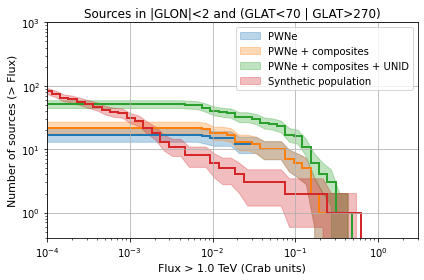

In [76]:
for s, sample in enumerate(samples[:]):
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes1_cut[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])
aaa = plotLogNlogS(final2.cr_fl_1, 10, color='C3', label='Synthetic population')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.title('Sources in |GLON|<2 and (GLAT<70 | GLAT>270)')
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('logNlogS_1TeV_HGPS_region.png', dpi=200, bbox_inches='tight')

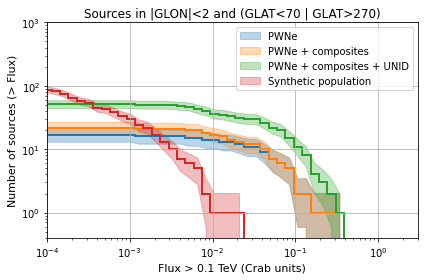

In [77]:
for s, sample in enumerate(samples[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes01_cut[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])
aaa = plotLogNlogS(final2.cr_fl_01, 10, color='C3', label='Synthetic population')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.title('Sources in |GLON|<2 and (GLAT<70 | GLAT>270)')
plt.xlabel("Flux > 0.1 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('logNlogS_0.1TeV_HGPS_region.png', dpi=200, bbox_inches='tight')

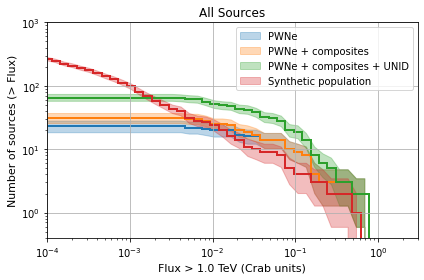

In [80]:
for s, sample in enumerate(samples[:]):
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes1[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])
aaa = plotLogNlogS(final.cr_fl_1, 10, color='C3', label='Synthetic population')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.title('All Sources')
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('logNlogS_1TeV_nocut.png', dpi=200, bbox_inches='tight')

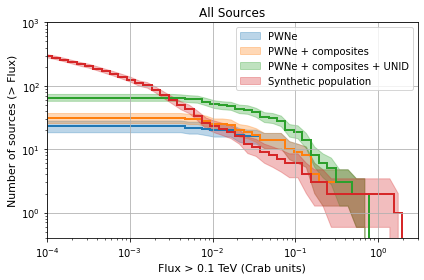

In [79]:
for s, sample in enumerate(samples[:]):
    # build mask to select desired sample
    mask = np.zeros(len(gammacat.table),dtype=bool)
    for c in sample['classes']:
        mask = np.logical_or(mask,gammacat.table['classes'] == c)
    # select sample
    flux_sample = fluxes01[mask==True]
    aa = plotLogNlogS(flux_sample, 10, label=sample['name'], color=color_cycle[s])
aaa = plotLogNlogS(final.cr_fl_01, 10, color='C3', label='Synthetic population')
plt.legend()
plt.xlim(1e-4, 0.3e1)
plt.ylim(0.39806199042692636, 1000)
plt.grid()
plt.title('All Sources')
plt.xlabel("Flux > 0.1 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('logNlogS_0.1TeV_nocut.png', dpi=200, bbox_inches='tight')

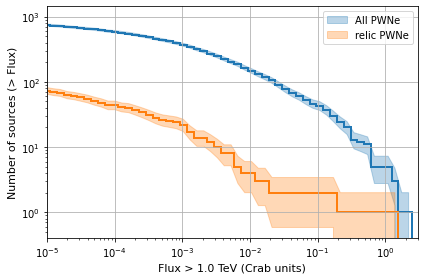

In [70]:
aa = plotLogNlogS(finalb.cr_fl_1_10, 10, label='All PWNe')
bb = plotLogNlogS(finalb.cr_fl_1_10[finalb.PSR_Escape == 1], 10, label='relic PWNe', color='C1')
plt.legend()
plt.xlim(1e-5, 0.3e1)
plt.grid()
plt.xlabel("Flux > 1.0 TeV (Crab units)", fontsize=11)
plt.ylabel('Number of sources (> Flux)', fontsize=11)
plt.tight_layout()
plt.savefig('logNlogS_relic_1.png',dpi=100, bbox_inches='tight')


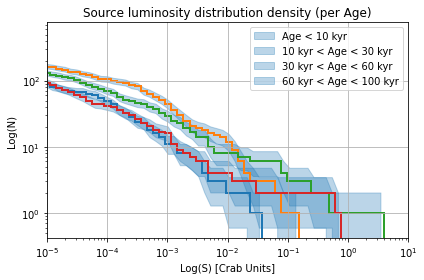

In [33]:
aa = plotLogNlogS(final.cr_fl_1_10[(final.age < 1e4)], 10, label='Age < 10 kyr', density=False)
aa = plotLogNlogS(final.cr_fl_1_10[(final.age > 1e4) & (final.age < 3e4)], 10, label='10 kyr < Age < 30 kyr', density=False)
aa = plotLogNlogS(final.cr_fl_1_10[(final.age > 3e4) & (final.age < 6e4)], 10, label='30 kyr < Age < 60 kyr', density=False)
aa = plotLogNlogS(final.cr_fl_1_10[(final.age > 6e4) & (final.age < 10e4)], 10, label='60 kyr < Age < 100 kyr', density=False)

# aa = plotLogNlogS(final.cr_fl_1_10[final.age < 6e4], 10, label='Age < 60 kyr')
# aa = plotLogNlogS(final.cr_fl_1_10[final.age < 8e4], 10, label='Age < 70 kyr')
# aa = plotLogNlogS(final.cr_fl_1_10, 10, label='Age < 70 kyr')

plt.title('Source luminosity distribution density (per Age)')
plt.ylabel('Log(N)')
plt.xlabel('Log(S) [Crab Units]')
plt.legend()
plt.xlim(1e-5, 1e1)
plt.grid()
plt.tight_layout()
plt.savefig('logNlogS_age.png',dpi=100, bbox_inches='tight')


In [34]:
finalb.t0, finalb.age

(N
 4       6.683078e+03
 7       9.478605e+02
 8       3.730954e+04
 9       1.421685e+05
 10      3.971101e+04
             ...     
 2925    3.065393e+06
 2926    2.393727e+05
 2929    2.234078e+04
 2932    1.733192e+05
 2934    5.596721e+04
 Name: t0, Length: 1299, dtype: float64,
 N
 4       88549.430065
 7         230.408224
 8       21155.059340
 9       94445.307703
 10      37890.508739
             ...     
 2925    92196.715194
 2926    96944.470657
 2929    48687.287606
 2932     8250.206848
 2934    11287.631869
 Name: age, Length: 1299, dtype: float64)

In [35]:
finalb['l_f'], finalb.l0

KeyError: 'l_f'

In [82]:
finalb['tc'] = finalb.t0+finalb.age
finalb['l_f'] = finalb.l0*(1+finalb.age/finalb.t0)**-2

In [83]:
def vol_ring(r_in, r_out):
    vol_int = 4/3 * np.pi * r_in**3
    vol_est = 4/3 * np.pi * r_out**3
    return vol_est-vol_int

In [84]:
vol_ring(1, 2), vol_ring(3, 4), 

(29.321531433504735, 154.98523757709646)

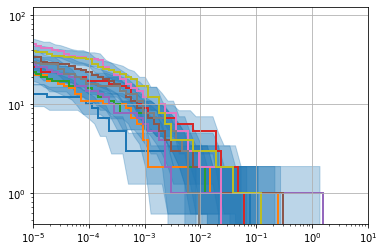

In [85]:
# aa = plotLogNlogS(final.cr_fl_1_10[final.cr_fl_1_10>1e-5],10)
# aa = plotLogNlogS(flux_int_cu[flux_int_cu>4e-4]/4,10)
aa = plotLogNlogS(final.cr_fl_1_10[(final.distance>=1.)&(final.distance<=2)],10, density=False)
bb = plotLogNlogS(final.cr_fl_1_10[(final.distance>=2.)&(final.distance<=3)],10, density=False)
cc = plotLogNlogS(final.cr_fl_1_10[(final.distance>=3.)&(final.distance<=4)],10, density=False)
dd = plotLogNlogS(final.cr_fl_1_10[(final.distance>=4.)&(final.distance<=5)],10, density=False)
ee = plotLogNlogS(final.cr_fl_1_10[(final.distance>=5.)&(final.distance<=6)],10, density=False)
ff = plotLogNlogS(final.cr_fl_1_10[(final.distance>=6.)&(final.distance<=7)],10, density=False)
gg = plotLogNlogS(final.cr_fl_1_10[(final.distance>=7.)&(final.distance<=8)],10, density=False)
ee = plotLogNlogS(final.cr_fl_1_10[(final.distance>=8.)&(final.distance<=9)],10, density=False)
ff = plotLogNlogS(final.cr_fl_1_10[(final.distance>=9.)&(final.distance<=10)],10, density=False)

# aa = plotLogNlogS(final.cr_fl_1_10[final.cr_fl_1_10>1e-5][(final.distance>=5.)&(final.distance<=6)],10)

plt.xlim(1e-5,1e1)
plt.grid()

In [86]:
aa

(array([17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
        17., 17., 17., 17., 16., 16., 16., 16., 15., 15., 15., 15., 15.,
        15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
        15., 15., 15., 15., 15., 14., 14., 14., 14., 13., 13., 13., 13.,
        12., 12., 12., 12., 12., 12., 11., 10.,  9.,  7.,  7.,  5.,  5.,
         5.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]),
 array([1.00000000e-10, 1.26158766e-10, 1.59160342e-10, 2.00794722e-10,
        2.53320143e-10, 3.19585566e-10, 4.03185205e-10, 5.08653478e-10,
        6.41710949e-10, 8.09574613e-10, 1.02134934e-09, 1.28852172e-09,
        1.62558310e-09, 2.05081557e-09, 2.58728361e-09, 3.26408506e-09,
        4.11792942e-09, 5.19512893e-09, 6.55411053e-09, 8.26858495e-09,
        1.04315447e-0

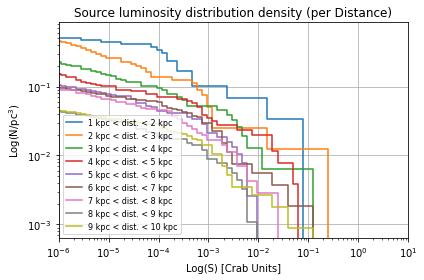

In [87]:
plt.loglog((aa[1][1:]+aa[1][:-1])/2,aa[0]/vol_ring(1, 2), drawstyle='steps-mid', label='1 kpc < dist. < 2 kpc')
plt.loglog((bb[1][1:]+bb[1][:-1])/2,bb[0]/vol_ring(2, 3), drawstyle='steps-mid', label='2 kpc < dist. < 3 kpc')
plt.loglog((cc[1][1:]+cc[1][:-1])/2,cc[0]/vol_ring(3, 4), drawstyle='steps-mid', label='3 kpc < dist. < 4 kpc')
plt.loglog((dd[1][1:]+dd[1][:-1])/2,dd[0]/vol_ring(4, 5), drawstyle='steps-mid', label='4 kpc < dist. < 5 kpc')
plt.loglog((ee[1][1:]+ee[1][:-1])/2,ee[0]/vol_ring(5, 6), drawstyle='steps-mid', label='5 kpc < dist. < 6 kpc')
plt.loglog((ff[1][1:]+ff[1][:-1])/2,ff[0]/vol_ring(6, 7), drawstyle='steps-mid', label='6 kpc < dist. < 7 kpc')
plt.loglog((gg[1][1:]+gg[1][:-1])/2,gg[0]/vol_ring(7, 8), drawstyle='steps-mid', label='7 kpc < dist. < 8 kpc')
plt.loglog((ee[1][1:]+ee[1][:-1])/2,ee[0]/vol_ring(8, 9), drawstyle='steps-mid', label='8 kpc < dist. < 9 kpc')
plt.loglog((ff[1][1:]+ff[1][:-1])/2,ff[0]/vol_ring(9, 10), drawstyle='steps-mid', label='9 kpc < dist. < 10 kpc')

plt.legend(loc='lower left', fontsize=8)
plt.title('Source luminosity distribution density (per Distance)')
plt.ylabel('Log(N/pc$^3$)')
plt.xlabel('Log(S) [Crab Units]')

plt.xlim(1e-6, 1e1)
plt.grid()
plt.tight_layout()
plt.savefig('logNlogS_distance.png',dpi=100, bbox_inches='tight')

In [88]:
len(finalb.tc[finalb.cr_fl_1_10>0.001])

118

In [89]:
finalb

,X,Y,Z,nh,age,v_X,v_Y,v_Z,v_3d,E_sn,...,R_fs,R_rs,R_pwn,PSR_Escape,filename,ph_fl_1_10,cr_fl_1_10,lum_1_10,tc,l_f
N,,,,,,,,,,,,,,,,,,,,,
4,3.233656,0.723182,-0.045045,1.681750,88549.430065,-146.825564,-6.108305,-251.525828,291.307913,1.000000e+51,...,28.804575,0.000000,0.149880,0.0,ph_sed_pwn_4.txt,3.627426e-19,1.091407e-08,3.145349e+24,9.523251e+04,3.539361e+33
7,-4.440427,2.668275,-0.078078,1.520002,230.408224,325.906008,334.230081,-104.594565,478.397843,1.000000e+51,...,1.442755,1.212399,0.214582,0.0,ph_sed_pwn_7.txt,1.023308e-13,3.078891e-03,1.847826e+30,1.178269e+03,3.187392e+38
8,-0.027860,7.576161,-0.618619,0.180014,21155.059340,460.049655,-44.847306,246.722924,523.955310,1.000000e+51,...,24.692818,4.432143,4.405102,0.0,ph_sed_pwn_8.txt,1.526829e-13,4.593868e-03,2.291487e+33,5.846460e+04,2.607269e+35
9,-4.095303,-3.818487,-1.177177,0.133924,94445.307703,395.612981,192.257992,251.077599,506.470855,1.000000e+51,...,48.940286,0.000000,0.448717,0.0,ph_sed_pwn_9.txt,2.043371e-16,6.148023e-06,1.393728e+28,2.366138e+05,2.946106e+34
10,10.282673,-0.804068,-0.042042,0.650150,37890.508739,-128.935190,3.298400,-138.038114,188.917134,1.000000e+51,...,24.556019,0.000000,0.152060,0.0,ph_sed_pwn_10.txt,8.231441e-17,2.476647e-06,8.460076e+26,7.760152e+04,6.614126e+34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,8.925042,-10.170694,-1.186186,0.006671,92196.715194,-95.617397,-23.448568,-35.078788,104.513364,1.000000e+51,...,86.975314,0.000000,2.442191,0.0,ph_sed_pwn_2925.txt,2.823270e-19,8.494554e-09,5.725445e+26,3.157590e+06,4.789925e+32
2926,5.942000,5.458640,1.108108,0.077704,96944.470657,13.180151,83.208796,105.733365,135.192324,1.000000e+51,...,54.773543,0.000000,1.138090,0.0,ph_sed_pwn_2926.txt,2.092638e-15,6.296255e-05,1.084822e+30,3.363172e+05,4.169900e+34
2929,-6.977273,-2.610356,-0.426426,0.244648,48687.287606,31.217723,127.068392,28.994138,134.020829,1.000000e+51,...,33.053413,0.000000,1.287676,0.0,ph_sed_pwn_2929.txt,1.264194e-16,3.803662e-06,1.154186e+29,7.102807e+04,5.302060e+34


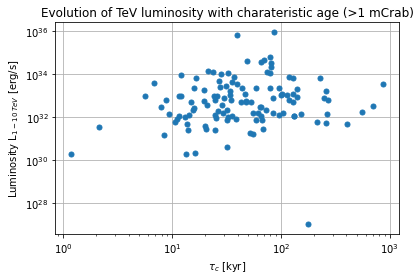

In [90]:
plt.loglog(finalb.tc[finalb.cr_fl_1_10>0.001]/1e3, finalb.lum_1_10[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel(r'$\tau _c$ [kyr]')
plt.ylabel('Luminosity L$_{1-10\; TeV}$ [erg/s]')
plt.title('Evolution of TeV luminosity with charateristic age (>1 mCrab)')
plt.tight_layout()
plt.savefig('EvoTevLum.png',dpi=100, bbox_inches='tight')

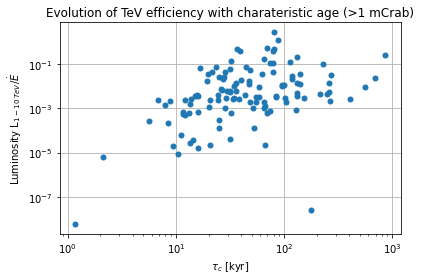

In [91]:
plt.loglog(finalb.tc[finalb.cr_fl_1_10>0.001]/1e3, finalb.lum_1_10[finalb.cr_fl_1_10>0.001]/finalb.l_f[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel(r'$\tau _c$ [kyr]')
plt.ylabel('Luminosity L$_{1-10\; TeV}/\dotE$')
plt.title('Evolution of TeV efficiency with charateristic age (>1 mCrab)')
plt.tight_layout()
plt.savefig('EvoTevEff.png',dpi=100, bbox_inches='tight')

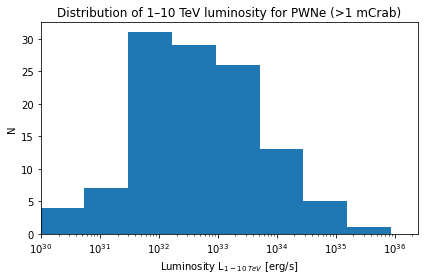

In [92]:
plot_loghist(finalb.lum_1_10[finalb.cr_fl_1_10>0.001], 12, 'lum', '', filen=None)
plt.xlabel('N')
plt.xlabel('Luminosity L$_{1-10\; TeV}$ [erg/s]')
plt.title('Distribution of 1–10 TeV luminosity for PWNe (>1 mCrab)')
plt.tight_layout()
plt.xlim(1e30)
plt.savefig('Distr_TevLum.png',dpi=100, bbox_inches='tight')

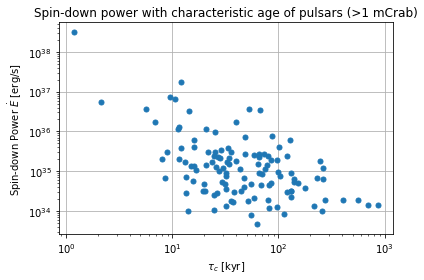

In [93]:
plt.loglog(finalb.tc[finalb.cr_fl_1_10>0.001]/1e3, finalb.l_f[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel(r'$\tau _c$ [kyr]')
plt.ylabel(r'Spin-down Power $\dotE$ [erg/s]')
plt.title('Spin-down power with characteristic age of pulsars (>1 mCrab)')
plt.tight_layout()
plt.savefig('EvoSpinDown.png',dpi=100, bbox_inches='tight')

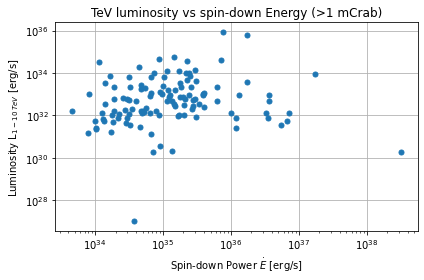

In [110]:
plt.loglog(finalb.l_f[finalb.cr_fl_1_10>0.001], finalb.lum_1_10[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel(r'Spin-down Power $\dotE$ [erg/s]')
plt.ylabel('Luminosity L$_{1-10\; TeV}$ [erg/s]')
plt.title('TeV luminosity vs spin-down Energy (>1 mCrab)')
plt.tight_layout()
plt.savefig('EvoTevLumvsEdot.png',dpi=100, bbox_inches='tight')

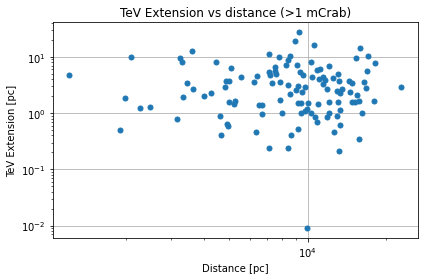

In [109]:
plt.loglog(finalb.distance[finalb.cr_fl_1_10>0.001]*1e3, finalb.R_pwn[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel('Distance [pc]')
plt.ylabel('TeV Extension [pc]')
plt.title('TeV Extension vs distance (>1 mCrab)')
plt.tight_layout()
plt.savefig('TeVextensionVSdistance.png',dpi=100, bbox_inches='tight')

(0.1, 100.0)

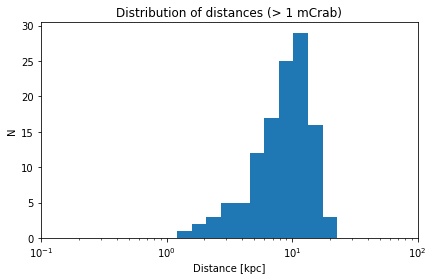

In [211]:
plot_loghist(finalb.distance[finalb.cr_fl_1_10>0.001], 11, 'lum', '', filen=None)
plt.xlabel('N')
plt.xlabel('Distance [kpc]')
plt.title('Distribution of distances (> 1 mCrab)')
plt.tight_layout()
plt.xlim(1e-1, 1e2)

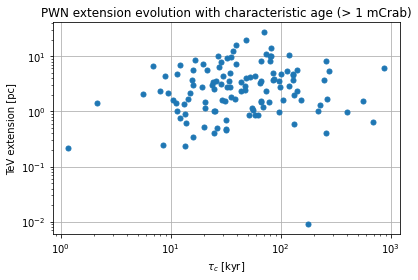

In [112]:
plt.loglog(finalb.tc[finalb.cr_fl_1_10>0.001]/1e3, finalb.R_pwn[finalb.cr_fl_1_10>0.001], '.', ms=10)
plt.grid()
plt.xlabel(r'$\tau _c$ [kyr]')
plt.ylabel(r'TeV extension [pc]')
plt.title('PWN extension evolution with characteristic age (> 1 mCrab)')
plt.tight_layout()
plt.savefig('EvoExtension.png',dpi=100, bbox_inches='tight')

In [213]:
(1*u.G).to('g/(C*s)')

<Quantity 0.1 g / (C s)>

In [214]:
BB = 

SyntaxError: invalid syntax (<ipython-input-214-927f107e1098>, line 1)

In [215]:
coords.Gal

NameError: name 'coords' is not defined

In [216]:
(1.4*u.M_sun).to('g')

<Quantity 2.78377382e+33 g>

In [284]:
RR = 1e6
II = 1e45
# BB = 0.17e12
# Mass = 2.7837738e33
omega = np.sqrt((2*finalb.tc*gp.yr_to_sec*finalb.l_f)/II)
BB = np.sqrt((3*gp.c_speed**3*II)/(4*RR**6*finalb.tc*gp.yr_to_sec*omega**2))
# omega = np.sqrt((3*gp.c_speed**3*II)/(2*RR**6*BB**2*(final.t0*gp.yr_to_sec)))

In [285]:
p0 = 2*np.pi/omega
pdot = p0/(2*finalb.tc*gp.yr_to_sec) 

final['p0'] = p0
final['pdot'] = pdot

In [287]:
fauch_p = np.loadtxt('../Computed_Population_20200410/faucher_p.txt').T
fauch_b = np.loadtxt('../Computed_Population_20200410/fauch_b.txt').T

<function matplotlib.pyplot.legend(*args, **kwargs)>

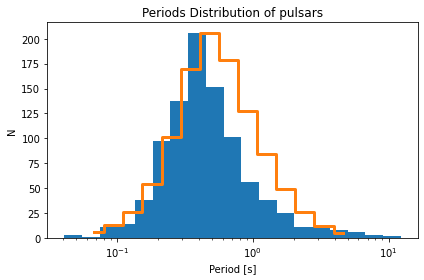

In [293]:
plot_loghist(p0, 19, 'Periods Distribution of pulsars', 'Period [s]')
# plt.xlim(1e-3, 3)
plt.semilogx(fauch_p[0], fauch_p[1], drawstyle='steps-mid', lw=3, label='From Faucher-Giguere')
#plot_loghist(distr_p0, 15, '', '')
# plt.xlim(1e-3, 3)

plt.legend
# plt.savefig('PeriodDistr_comparison.png',dpi=100, bbox_inches='tight')

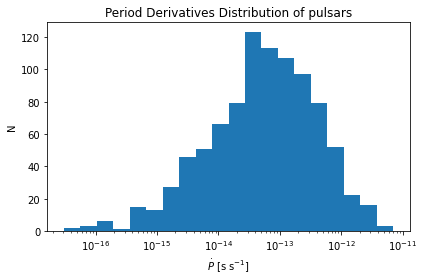

In [289]:
plot_loghist(pdot, 20, 'Period Derivatives Distribution of pulsars', '$\dotP$ [s s$^{-1}$]')
plt.savefig('PeriodDerivDistr.png',dpi=100, bbox_inches='tight')

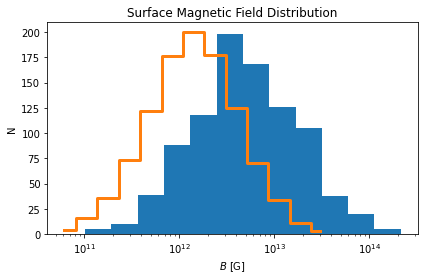

In [290]:
plot_loghist(BB, 12, 'Surface Magnetic Field Distribution', '$B$ [G]')
plt.semilogx(fauch_b[0], fauch_b[1], drawstyle='steps-mid', lw=3, label='From Faucher-Giguere')

plt.savefig('SurfaceMagField_comparison.png',dpi=100, bbox_inches='tight')

In [76]:
len(fauch_b[0])

13

In [294]:
xxx = np.linspace(0.01, 20)
yyy = xxx/(200e3*gp.yr_to_sec)
yyy2 = xxx/(200e2*gp.yr_to_sec)
yyy1 = xxx/(200e1*gp.yr_to_sec)
yyy3 = xxx/(200e4*gp.yr_to_sec)


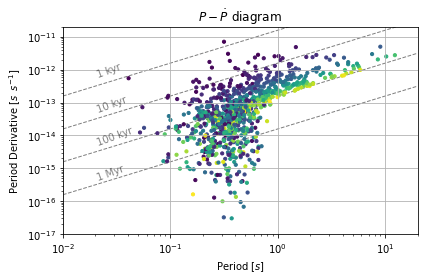

In [295]:
plt.loglog()
plt.scatter(final.p0, final.pdot, c=final.age, s=10)
plt.plot(xxx,yyy, '--k', alpha=0.5, zorder=-10, lw=1)
plt.plot(xxx,yyy2, '--k', alpha=0.5, zorder=-10, lw=1)
plt.plot(xxx,yyy1, '--k', alpha=0.5, zorder=-10, lw=1)
plt.plot(xxx,yyy3, '--k', alpha=0.5, zorder=-10, lw=1)
plt.text(0.02, 6e-13, '1 kyr', rotation=20, alpha=0.5,)
plt.text(0.02, 5e-14, '10 kyr', rotation=20, alpha=0.5,)
plt.text(0.02, 5e-15, '100 kyr', rotation=20, alpha=0.5,)
plt.text(0.02, 4.5e-16, '1 Myr', rotation=20, alpha=0.5,)

plt.grid()
plt.xlabel(r'Period [$s$]')
plt.ylabel(r'Period Derivative [$s\;\;s^{-1}$]')
plt.title('$P - \dotP$ diagram')
plt.xlim(0.01, 20)

plt.ylim(1e-17, 2e-11)
plt.tight_layout()
plt.savefig('PPdiagram.png',dpi=100, bbox_inches='tight')

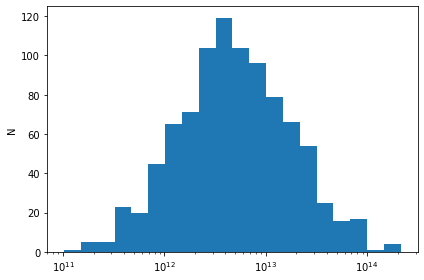

In [296]:
plot_loghist(BB, 20, '', '')

In [402]:
(1*u.G).to('g/(C*s)')

<Quantity 0.1 g / (C s)>

In [373]:
final.t0

N
1         482.112122
2         118.869165
5         451.034621
8         225.011032
15       4070.639238
18       5594.567411
19      21524.178992
21       4881.059343
22       1370.315657
23       3652.248392
24       9908.348550
25      17272.670846
32        890.995905
34        551.604430
35         95.559664
39        155.657021
49        450.982530
54        570.551226
56       1142.688357
58        390.608990
62       7164.967721
66        285.868945
73        731.279031
77       3241.472332
84        727.135919
85      24561.253125
90       1878.768910
94        259.273561
98      16457.522929
100      2903.638139
            ...     
2908     2334.698836
2910     1117.953279
2916      606.042372
2919      328.017189
2920      128.407724
2921      104.100541
2923     1450.474686
2924     1018.859402
2926     2076.091043
2930     1200.666453
2931      857.431766
2933      940.485803
2942      354.730138
2945    10275.544262
2948      859.983467
2949      543.623121
2951     15